In [2]:
import pandas as pd
df = pd.read_csv("/home/farhana/Documents/chipless-RFID-tag-decoding-XGBClassifier/dataset/data_2/set_5.csv")

# Select the last column of the DataFrame
last_column = df.iloc[:, -2]
X_train = df.iloc[:, :-2]
print(X_train)

      index         0         1         2         3         4         5  \
0         0 -41.05859 -45.22265 -48.47461 -45.05859 -43.61133 -42.35547   
1         1 -41.71875 -44.71289 -47.19140 -45.77148 -44.66210 -42.69531   
2         2 -44.21094 -50.81836 -60.81640 -47.71289 -44.87500 -43.44727   
3         3 -45.32812 -50.61718 -52.30273 -45.50977 -43.71094 -42.24609   
4         4 -44.56055 -48.62890 -52.46288 -45.85742 -43.56641 -42.42383   
...     ...       ...       ...       ...       ...       ...       ...   
1425    465 -48.99023 -46.34179 -44.43359 -44.37500 -46.00390 -48.68750   
1426    466 -48.53516 -46.49219 -44.67773 -43.86914 -44.97070 -47.18946   
1427    467 -51.35156 -48.44921 -46.46680 -46.43164 -48.39453 -52.57421   
1428    468 -56.33007 -51.62499 -48.89062 -47.68750 -49.25390 -52.49804   
1429    469 -55.02539 -50.90234 -47.97852 -47.61328 -49.94141 -53.94921   

             6         7         8  ...      1591      1592      1593  \
0    -40.64453 -40.85742 -

In [3]:
import numpy as np

# Load your frequency response data into a variable, e.g., "frequency_response_data"
frequency_response_data = X_train

# 1. Center the data
mean = np.mean(frequency_response_data)
frequency_response_data -= mean

# 2. Scale the data
std_dev = np.std(frequency_response_data)
frequency_response_data /= std_dev

# 3. Clip extreme values (optional)
# You can set a threshold to clip values if needed
# frequency_response_data = np.clip(frequency_response_data, min_threshold, max_threshold)

# 4. Ensure the input range is appropriate for GAN activations
# If your GAN uses tanh activation in the generator, scale data to [-1, 1] range
# frequency_response_data *= 2  # Scale to [-1, 1]

# Now, your frequency response data is centered, scaled, and potentially clipped, ready for GAN training.
print(frequency_response_data)

         index         0         1         2         3         4         5  \
0    -1.213399  1.184518  0.487298  0.016102  0.603862  0.930629  1.212474   
1    -1.209172  1.073694  0.565471  0.216777  0.492534  0.768071  1.159879   
2    -1.204946  0.655316 -0.370812 -1.913967  0.189355  0.735134  1.043503   
3    -1.200719  0.467768 -0.339960 -0.582558  0.533403  0.915219  1.229402   
4    -1.196493  0.596625 -0.035055 -0.607603  0.479113  0.937578  1.201895   
...        ...       ...       ...       ...       ...       ...       ...   
1425  0.751962 -0.147011  0.315677  0.648056  0.710614  0.560489  0.232502   
1426  0.756189 -0.070615  0.292613  0.609877  0.789611  0.720329  0.464345   
1427  0.760416 -0.543420 -0.007499  0.330093  0.389440  0.190650 -0.369022   
1428  0.764642 -1.379191 -0.494509 -0.048956  0.193320  0.057702 -0.357234   
1429  0.768869 -1.160167 -0.383690  0.093683  0.204911 -0.048658 -0.581823   

             6         7         8  ...      1591      1592    

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

# Load and preprocess your dataset (assuming you've done this)
# Drop the "Tag_names" column if it represents labels
# Normalize the data
# For simplicity, let's assume your preprocessed data is stored in a variable named "data"
data = frequency_response_data

# Normalize the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Define the GAN architecture
latent_dim = 1000  # Size of the random noise vector

# Generator
generator = keras.Sequential([
    keras.layers.Dense(128, input_dim=latent_dim, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(data.shape[1], activation='linear')
])

# Discriminator
discriminator = keras.Sequential([
    keras.layers.Dense(64, input_dim=data.shape[1], activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# The combined GAN model (stacked generator and discriminator)
discriminator.trainable = False  # We only want to train the generator
gan_input = keras.Input(shape=(latent_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = keras.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

# Training the GAN
batch_size = 32
epochs = 100  # You may need more epochs depending on your dataset and complexity
d_loss_real_l = []
d_loss_fake_l = []
g_loss_l = []

for epoch in range(epochs):
    # Train discriminator (real data)
    real_data = data[np.random.randint(0, data.shape[0], batch_size)]
    real_labels = np.ones((batch_size, 1))
    d_loss_real = discriminator.train_on_batch(real_data, real_labels)
    d_loss_real_l.append(d_loss_real)
    
    # Train discriminator (generated data)
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generated_data = generator.predict(noise)
    fake_labels = np.zeros((batch_size, 1))
    d_loss_fake = discriminator.train_on_batch(generated_data, fake_labels)
    d_loss_fake_l.append(d_loss_fake)
    
    # Train generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    valid_labels = np.ones((batch_size, 1))
    g_loss = gan.train_on_batch(noise, valid_labels)
    g_loss_l.append(g_loss)
    
    # Print progress
    print(f"Epoch {epoch}/{epochs} | D Loss Real: {d_loss_real[0]} | D Loss Fake: {d_loss_fake[0]} | G Loss: {g_loss}")

# Anomaly Detection
def detect_anomalies(data):
    noise = np.random.normal(0, 1, (data.shape[0], latent_dim))
    generated_data = generator.predict(noise)
    real_labels = np.ones((data.shape[0], 1))
    discriminator_output = discriminator.predict(data)
    anomaly_scores = np.abs(discriminator_output - real_labels)
    return anomaly_scores

# Detect anomalies in your data
anomaly_scores = detect_anomalies(data)

# Set a threshold to classify anomalies
threshold = 0.5  # Adjust as needed
anomalies = anomaly_scores > threshold

# Print the indices of anomalies in your dataset
print("Indices of anomalies:")
print(np.where(anomalies))


Epoch 0/100 | D Loss Real: 0.5859505534172058 | D Loss Fake: 0.6406958699226379 | G Loss: 0.8825051784515381
Epoch 1/100 | D Loss Real: 0.2720026969909668 | D Loss Fake: 0.7701944708824158 | G Loss: 0.6912173628807068
Epoch 2/100 | D Loss Real: 0.18339619040489197 | D Loss Fake: 0.8618831038475037 | G Loss: 0.5935651063919067
Epoch 3/100 | D Loss Real: 0.08132870495319366 | D Loss Fake: 0.946675717830658 | G Loss: 0.5508639812469482
Epoch 4/100 | D Loss Real: 0.0759250745177269 | D Loss Fake: 0.9840359687805176 | G Loss: 0.5136846303939819
Epoch 5/100 | D Loss Real: 0.018839508295059204 | D Loss Fake: 1.099239468574524 | G Loss: 0.4941609799861908
Epoch 6/100 | D Loss Real: 0.026611708104610443 | D Loss Fake: 1.089626431465149 | G Loss: 0.48318779468536377
Epoch 7/100 | D Loss Real: 0.017019130289554596 | D Loss Fake: 1.0777614116668701 | G Loss: 0.47777146100997925
Epoch 8/100 | D Loss Real: 0.04058036208152771 | D Loss Fake: 1.081522822380066 | G Loss: 0.49572208523750305
Epoch 9/100

Epoch 75/100 | D Loss Real: 0.008822113275527954 | D Loss Fake: 0.30086612701416016 | G Loss: 1.426668643951416
Epoch 76/100 | D Loss Real: 0.0011294130235910416 | D Loss Fake: 0.30110669136047363 | G Loss: 1.4621789455413818
Epoch 77/100 | D Loss Real: 0.009550325572490692 | D Loss Fake: 0.3083590269088745 | G Loss: 1.4661450386047363
Epoch 78/100 | D Loss Real: 0.0020311283878982067 | D Loss Fake: 0.3059195876121521 | G Loss: 1.433401346206665
Epoch 79/100 | D Loss Real: 0.0024919742718338966 | D Loss Fake: 0.3151397705078125 | G Loss: 1.4382381439208984
Epoch 80/100 | D Loss Real: 0.004230001010000706 | D Loss Fake: 0.31668952107429504 | G Loss: 1.4454747438430786
Epoch 81/100 | D Loss Real: 0.003788800910115242 | D Loss Fake: 0.3101983666419983 | G Loss: 1.440474510192871
Epoch 82/100 | D Loss Real: 0.004847531672567129 | D Loss Fake: 0.30688387155532837 | G Loss: 1.4203860759735107
Epoch 83/100 | D Loss Real: 0.0010964847169816494 | D Loss Fake: 0.29752448201179504 | G Loss: 1.475

In [19]:
anomalies = (np.array([781, 782, 784, 792, 793, 795, 798, 944]), np.array([0, 0, 0, 0, 0, 0, 0, 0]))
anomaly_indices = anomalies[0]
anomalies_data = X_train.iloc[anomaly_indices]
print(anomalies_data)

        index         0         1         2         3         4         5  \
781 -0.617451 -0.675884 -0.803609 -0.822939 -1.067887 -0.482252 -0.317334   
782 -0.613224 -0.716215 -0.823976 -0.814692 -0.931549 -0.714609 -0.323077   
784 -0.604771 -3.029422 -3.185348 -2.598151 -3.213010 -2.231432 -1.239875   
792 -0.570958 -1.475261 -1.767147 -2.416109 -2.560902 -2.083677 -2.319296   
793 -0.566732 -0.902451 -0.915028 -0.995207 -1.194162 -1.631048 -2.084428   
795 -0.558278 -1.051310 -0.985116 -0.798808 -1.236862 -2.214814 -1.719282   
798 -0.545599 -1.239515 -1.124988 -1.154035 -1.436337 -1.238244 -1.334183   
944  0.071482  0.277597  0.050307 -0.258793 -0.345018 -0.244152 -0.464541   

            6         7         8  ...      1591      1592      1593  \
781  0.000004 -0.346889 -0.074881  ...  0.149746  0.123940  0.150105   
782 -0.091948 -0.447036  0.068650  ...  0.159245  0.185383  0.167853   
784 -1.277529 -1.509438 -0.857229  ...  0.319423  0.290804  0.306242   
792 -3.593220 -4.6

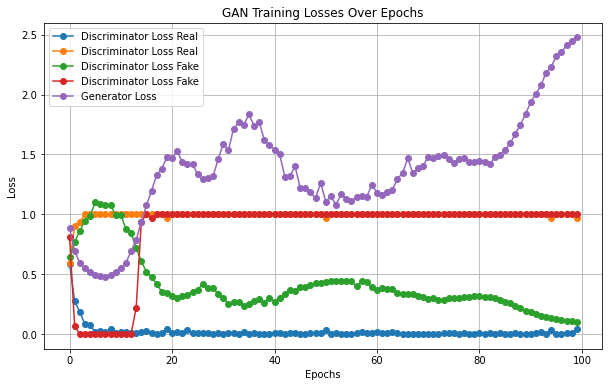

In [6]:
import matplotlib.pyplot as plt

# Your epoch and loss data
epochs = list(range(100))
d_loss_real = d_loss_real_l  # Replace ellipsis with your data
d_loss_fake = d_loss_fake_l
g_loss = g_loss_l

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(epochs, d_loss_real, label='Discriminator Loss Real', marker='o')
plt.plot(epochs, d_loss_fake, label='Discriminator Loss Fake', marker='o')
plt.plot(epochs, g_loss, label='Generator Loss', marker='o')

plt.title('GAN Training Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
